In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import sys
sys.path
sys.path.append('..')

import helpers
%matplotlib inline 

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,7)


In [24]:
arr=np.array([[1,2],[2,2], [3,4]])

arr

array([[-1,  1],
       [ 2,  2],
       [-1,  1]])

In [3]:
arr_simple = np.load("../data/AA66266AA.npy",allow_pickle=True)
arr_double = np.load("../data/AA662266AA.npy",allow_pickle=True)

In [9]:
print("Simple polymer shape ", arr_simple.shape, arr_simple[0].shape)
print("Double polymer shape ", arr_double.shape, arr_double[0].shape)

Simple polymer shape  (22039,) (425, 2)
Double polymer shape  (50957,) (419, 2)


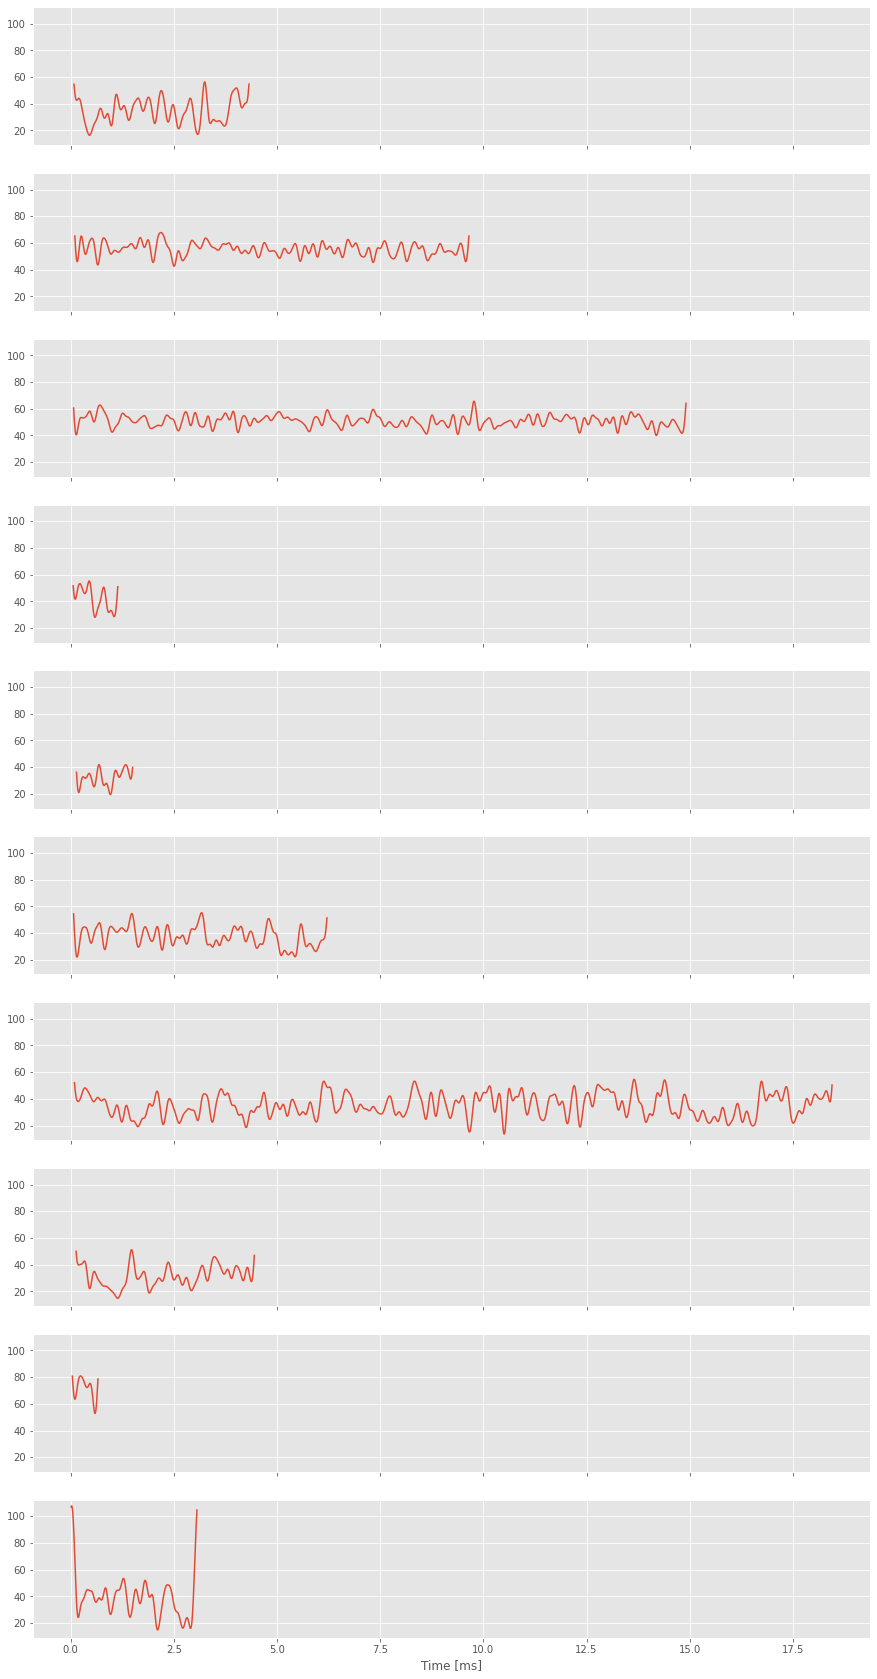

In [10]:
k = 10
fig, axes = plt.subplots(k,1, figsize=(15,30), sharex=True, sharey=True)

for i in range(k):
    obs = arr_simple[i]
    time = obs[:,0]
    current = obs[:,1]

    g= sns.lineplot(x=time,y=current, ax=axes[i])
    g.set_xlabel("Time [ms]")

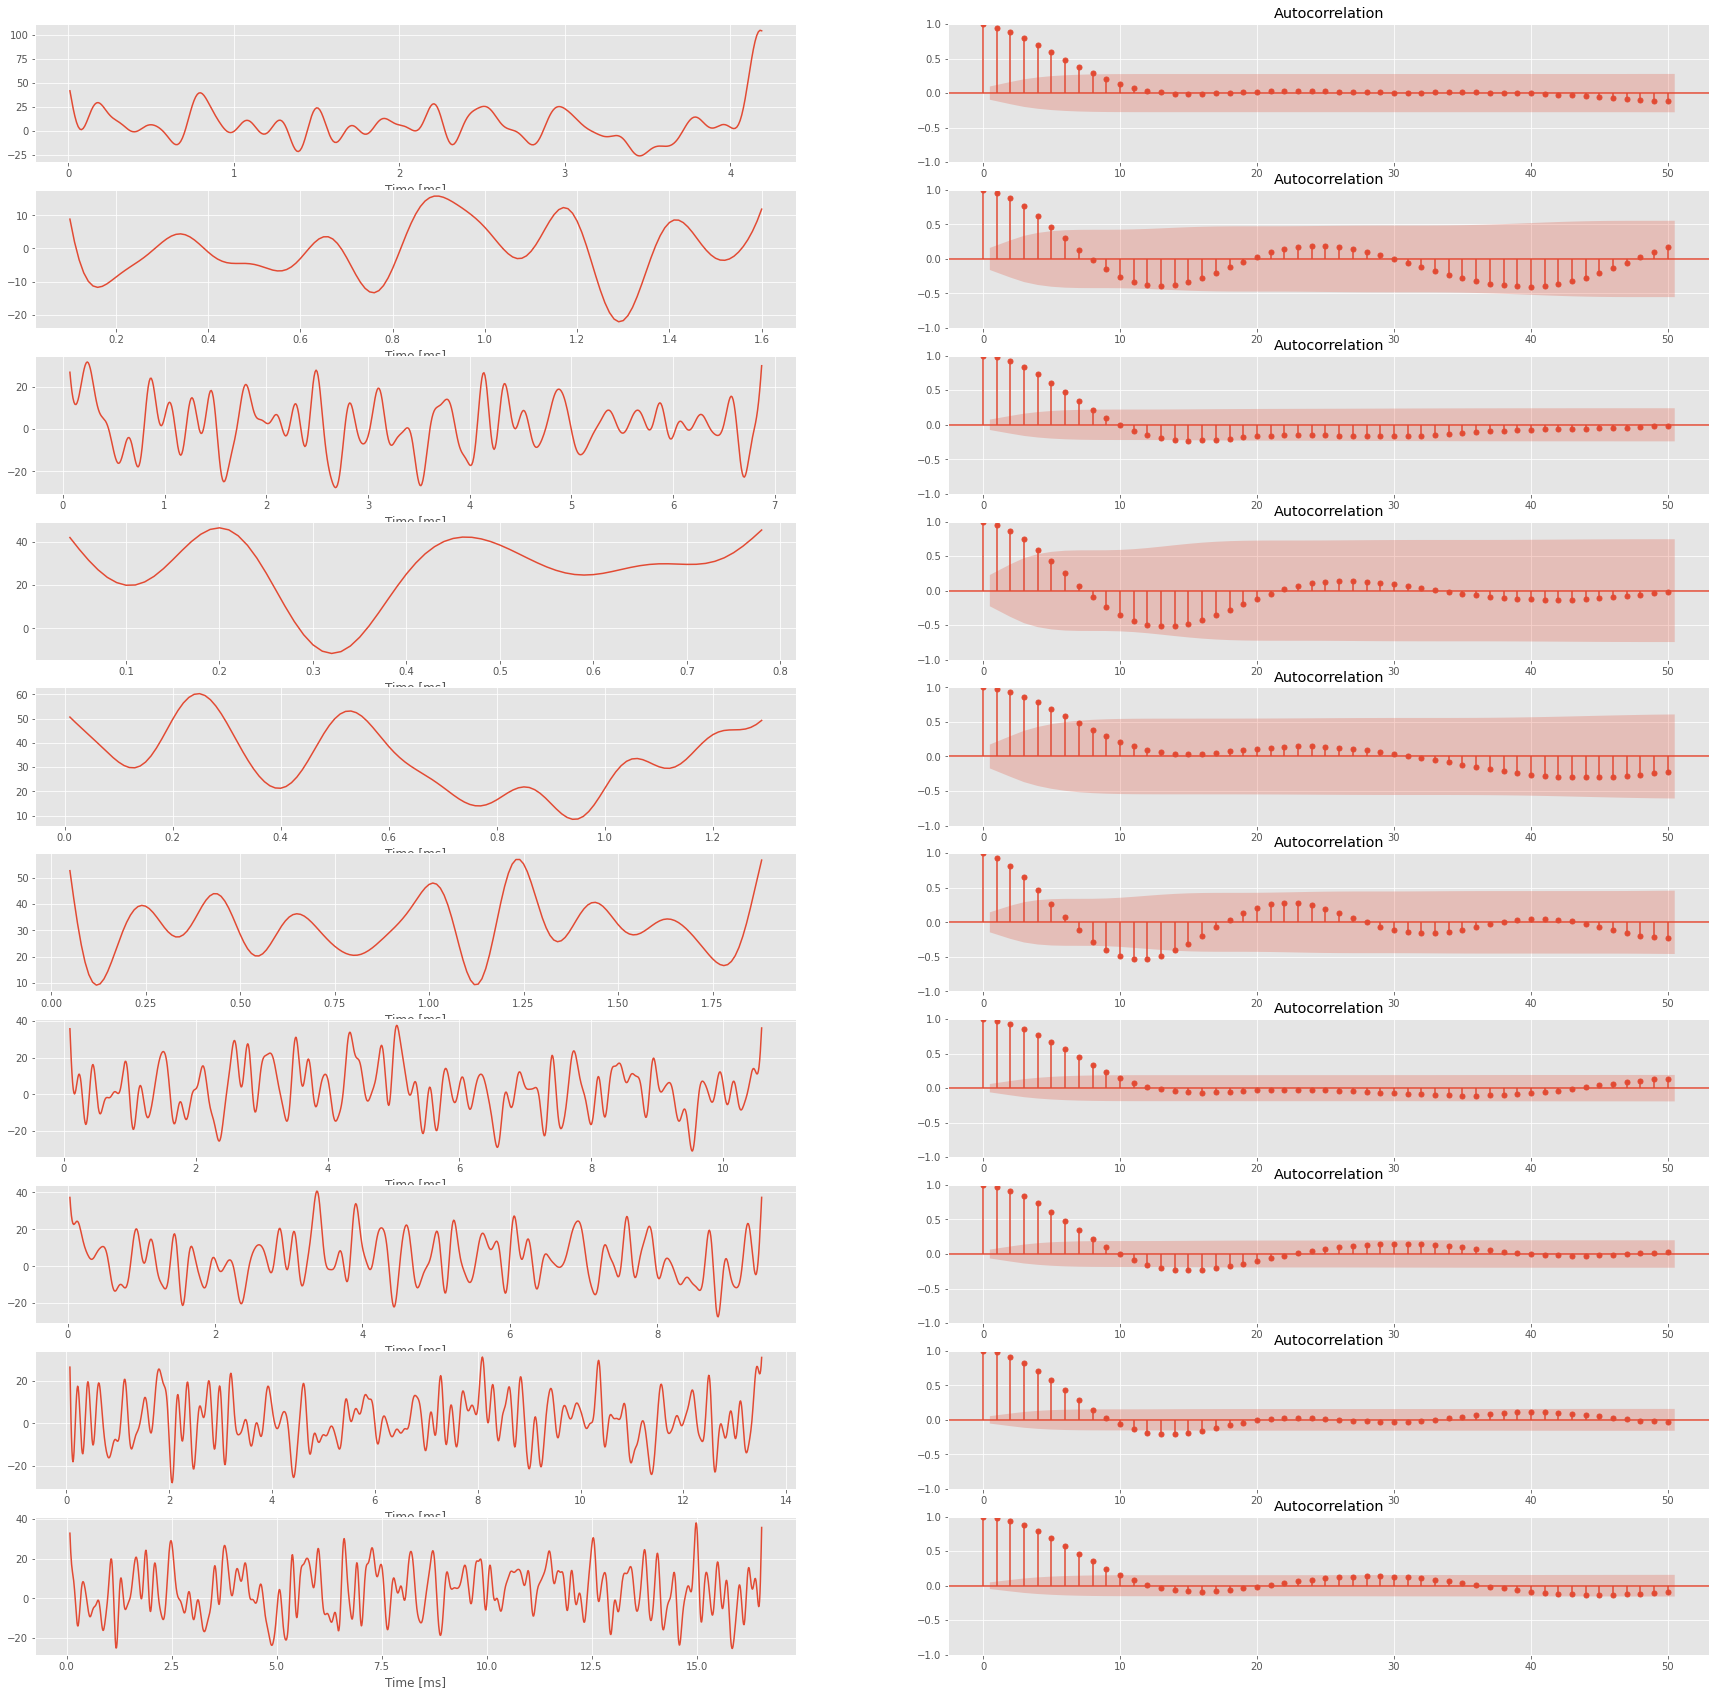

In [21]:
k = 10
fig, axes = plt.subplots(k,2, figsize=(30,30))

for i in range(k):
    obs = arr_double[i]
    time = obs[:,0]
    current = obs[:,1]
    g= sns.lineplot(x=time,y=current, ax=axes[i,0])
    plot_acf(current, lags=50, ax=axes[i,1])
    g.set_xlabel("Time [ms]")

In [ ]:
arr_simple[0][-1,0]

4.32

In [16]:
auto_corr=acf(arr_simple[0][:,1], fft=True)
np.vstack((auto_corr, np.zeros(len(auto_corr))))

TypeError: _vhstack_dispatcher() got an unexpected keyword argument 'axis'

In [7]:
def count_extremums(current):
    if len(current)<3:
        return 0
    increasing = current[0]<current[1]
    tmp=current[0]
    counter = 0
    values=[]
    for i in current[1:]:
        if increasing and i<tmp:
            increasing = False
            counter +=1
            values.append(i)
        elif not increasing and i>tmp:
            increasing=True
            counter+=1
            values.append(i)

        tmp=i
    return counter

In [8]:
def extract_features(row):
    length=row[-1,0]
    current=row[:,1]
    mean_current=np.mean(current)
    max_current=np.max(current)
    min_current=np.min(current)
    extremum_count=count_extremums(current)
    return (length, mean_current, max_current, min_current, extremum_count)
    


In [9]:
length, mean_current, max_current, min_current, extremum_count=extract_features(arr_simple[0])

In [10]:
def get_extracted_features(arr, plot=False):
    lengths=[]
    means=[]
    maxs=[]
    mins=[]
    extremum_counts=[]
    
    for row in arr:
        length, mean_current, max_current, min_current, extremum_count=extract_features(row)
        lengths.append(length)
        means.append(mean_current)
        maxs.append(max_current)
        mins.append(min_current)
        extremum_counts.append(extremum_count)
    if plot:
        fig, axes = plt.subplots(5,1, figsize=(30,30))
        sns.histplot(lengths, ax=axes[0]).set_title("lengths")
        sns.histplot(means, ax=axes[1]).set_title("means")
        sns.histplot(maxs, ax=axes[2]).set_title("maxs")
        sns.histplot(mins, ax=axes[3]).set_title("mins")
        sns.histplot(extremum_counts, ax=axes[4]).set_title("extremum counts")
    return np.array([np.array(lengths),np.array(means),np.array(maxs),np.array(mins),np.array(extremum_counts)])


In [30]:
def normalize(x):
    return (x-np.mean(x,axis=1))/np.std(x,axis=1)

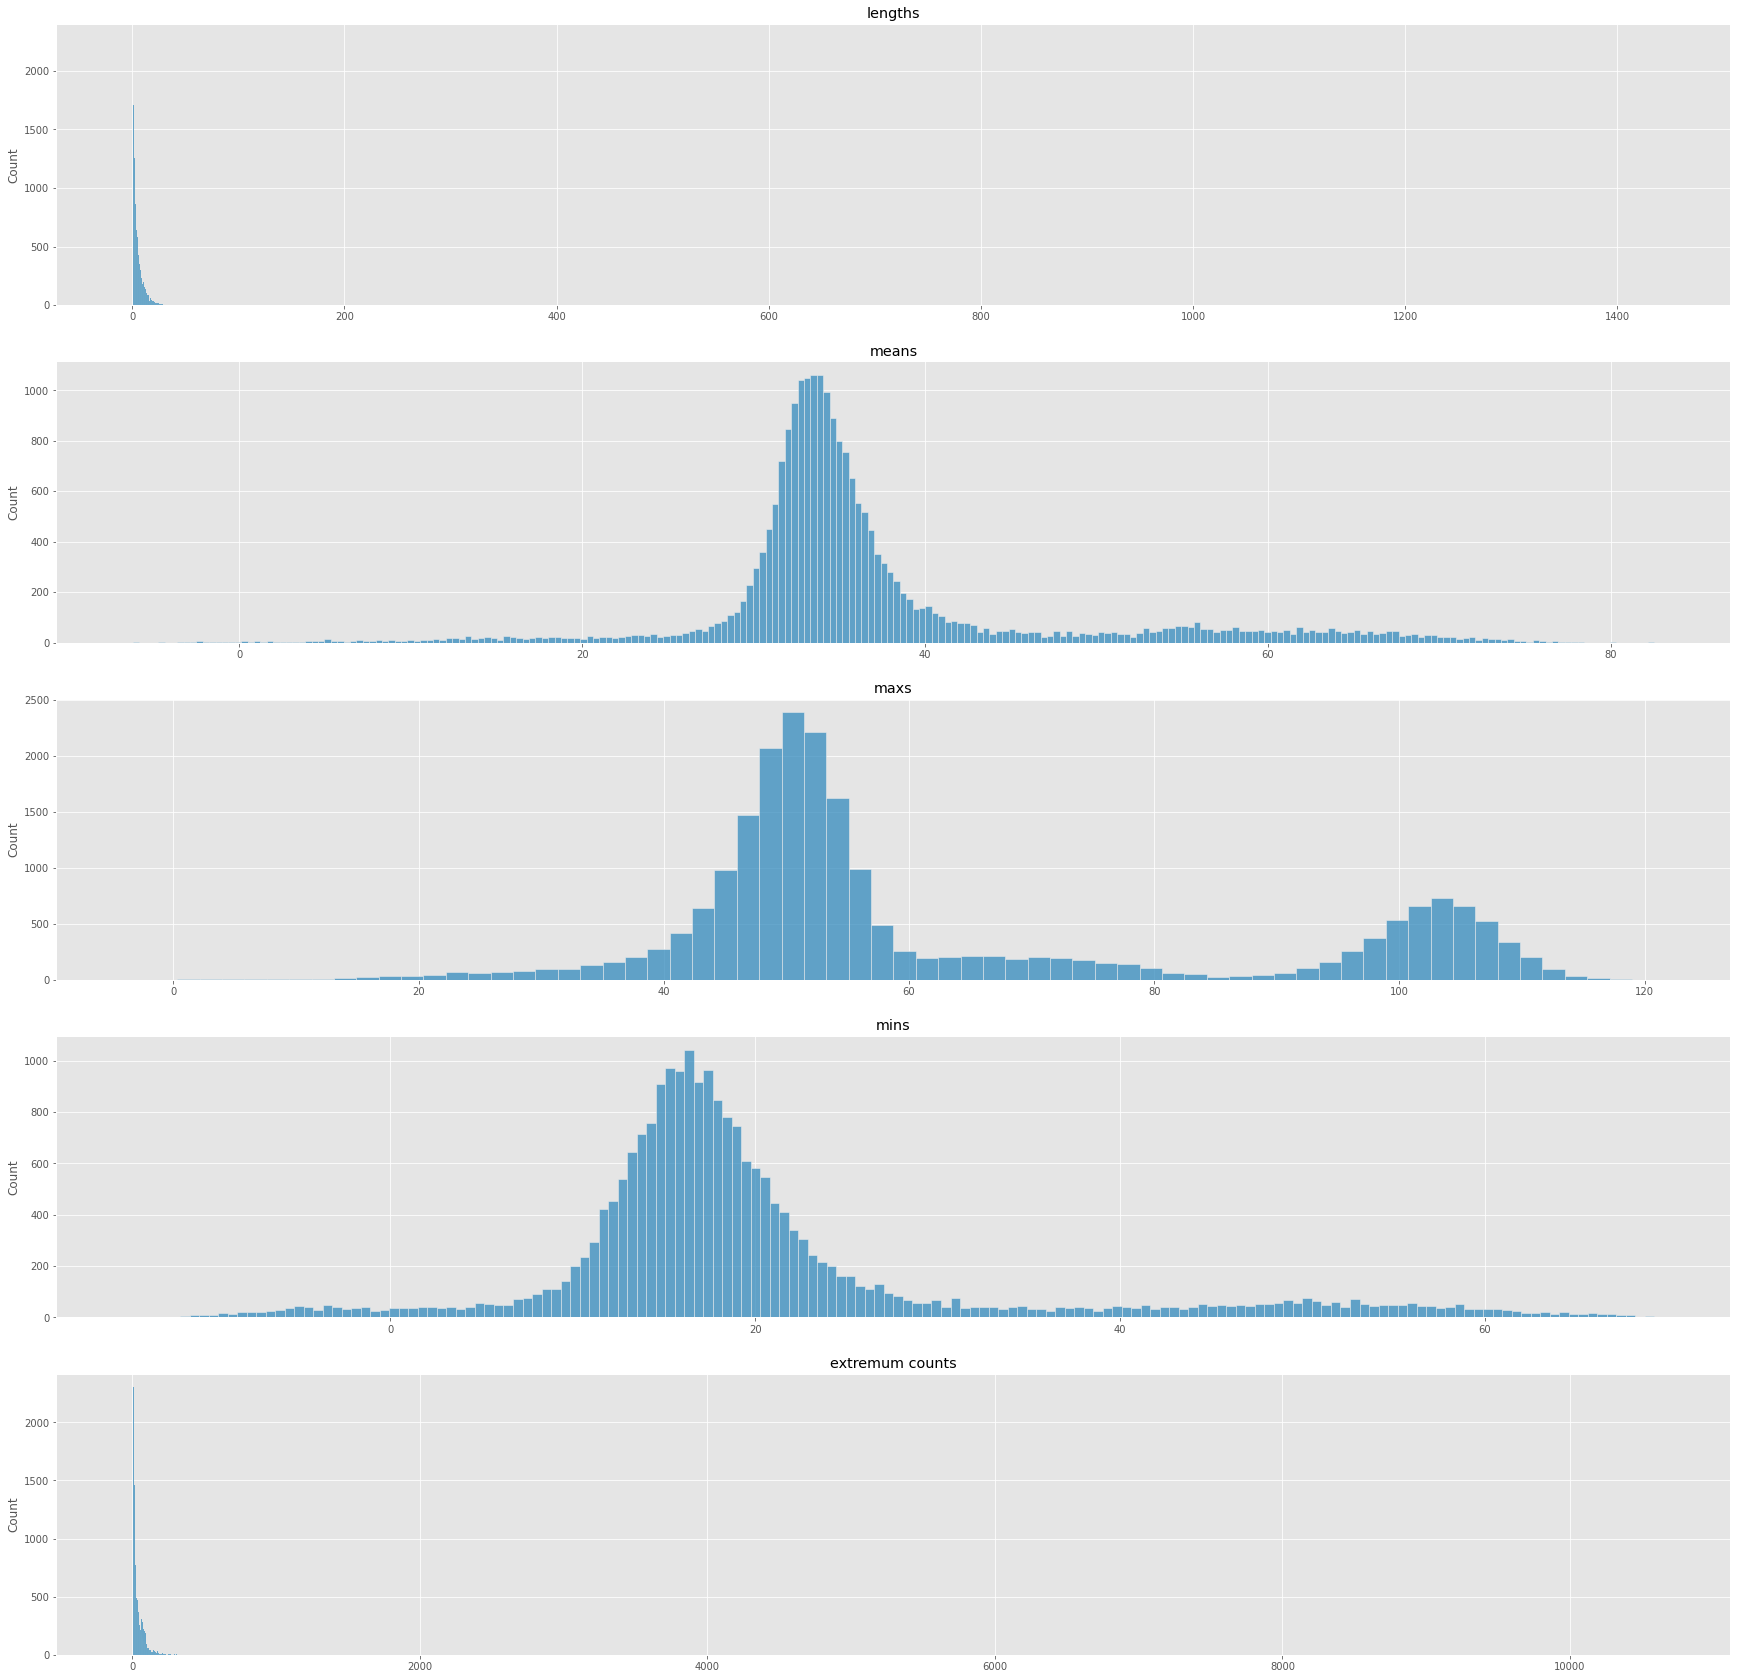

In [11]:
simpleX=get_extracted_features(arr_simple, plot=True).T

In [12]:
df_simple=pd.DataFrame(simpleX, columns=["length", "mean", "max", "min", "extremum"])

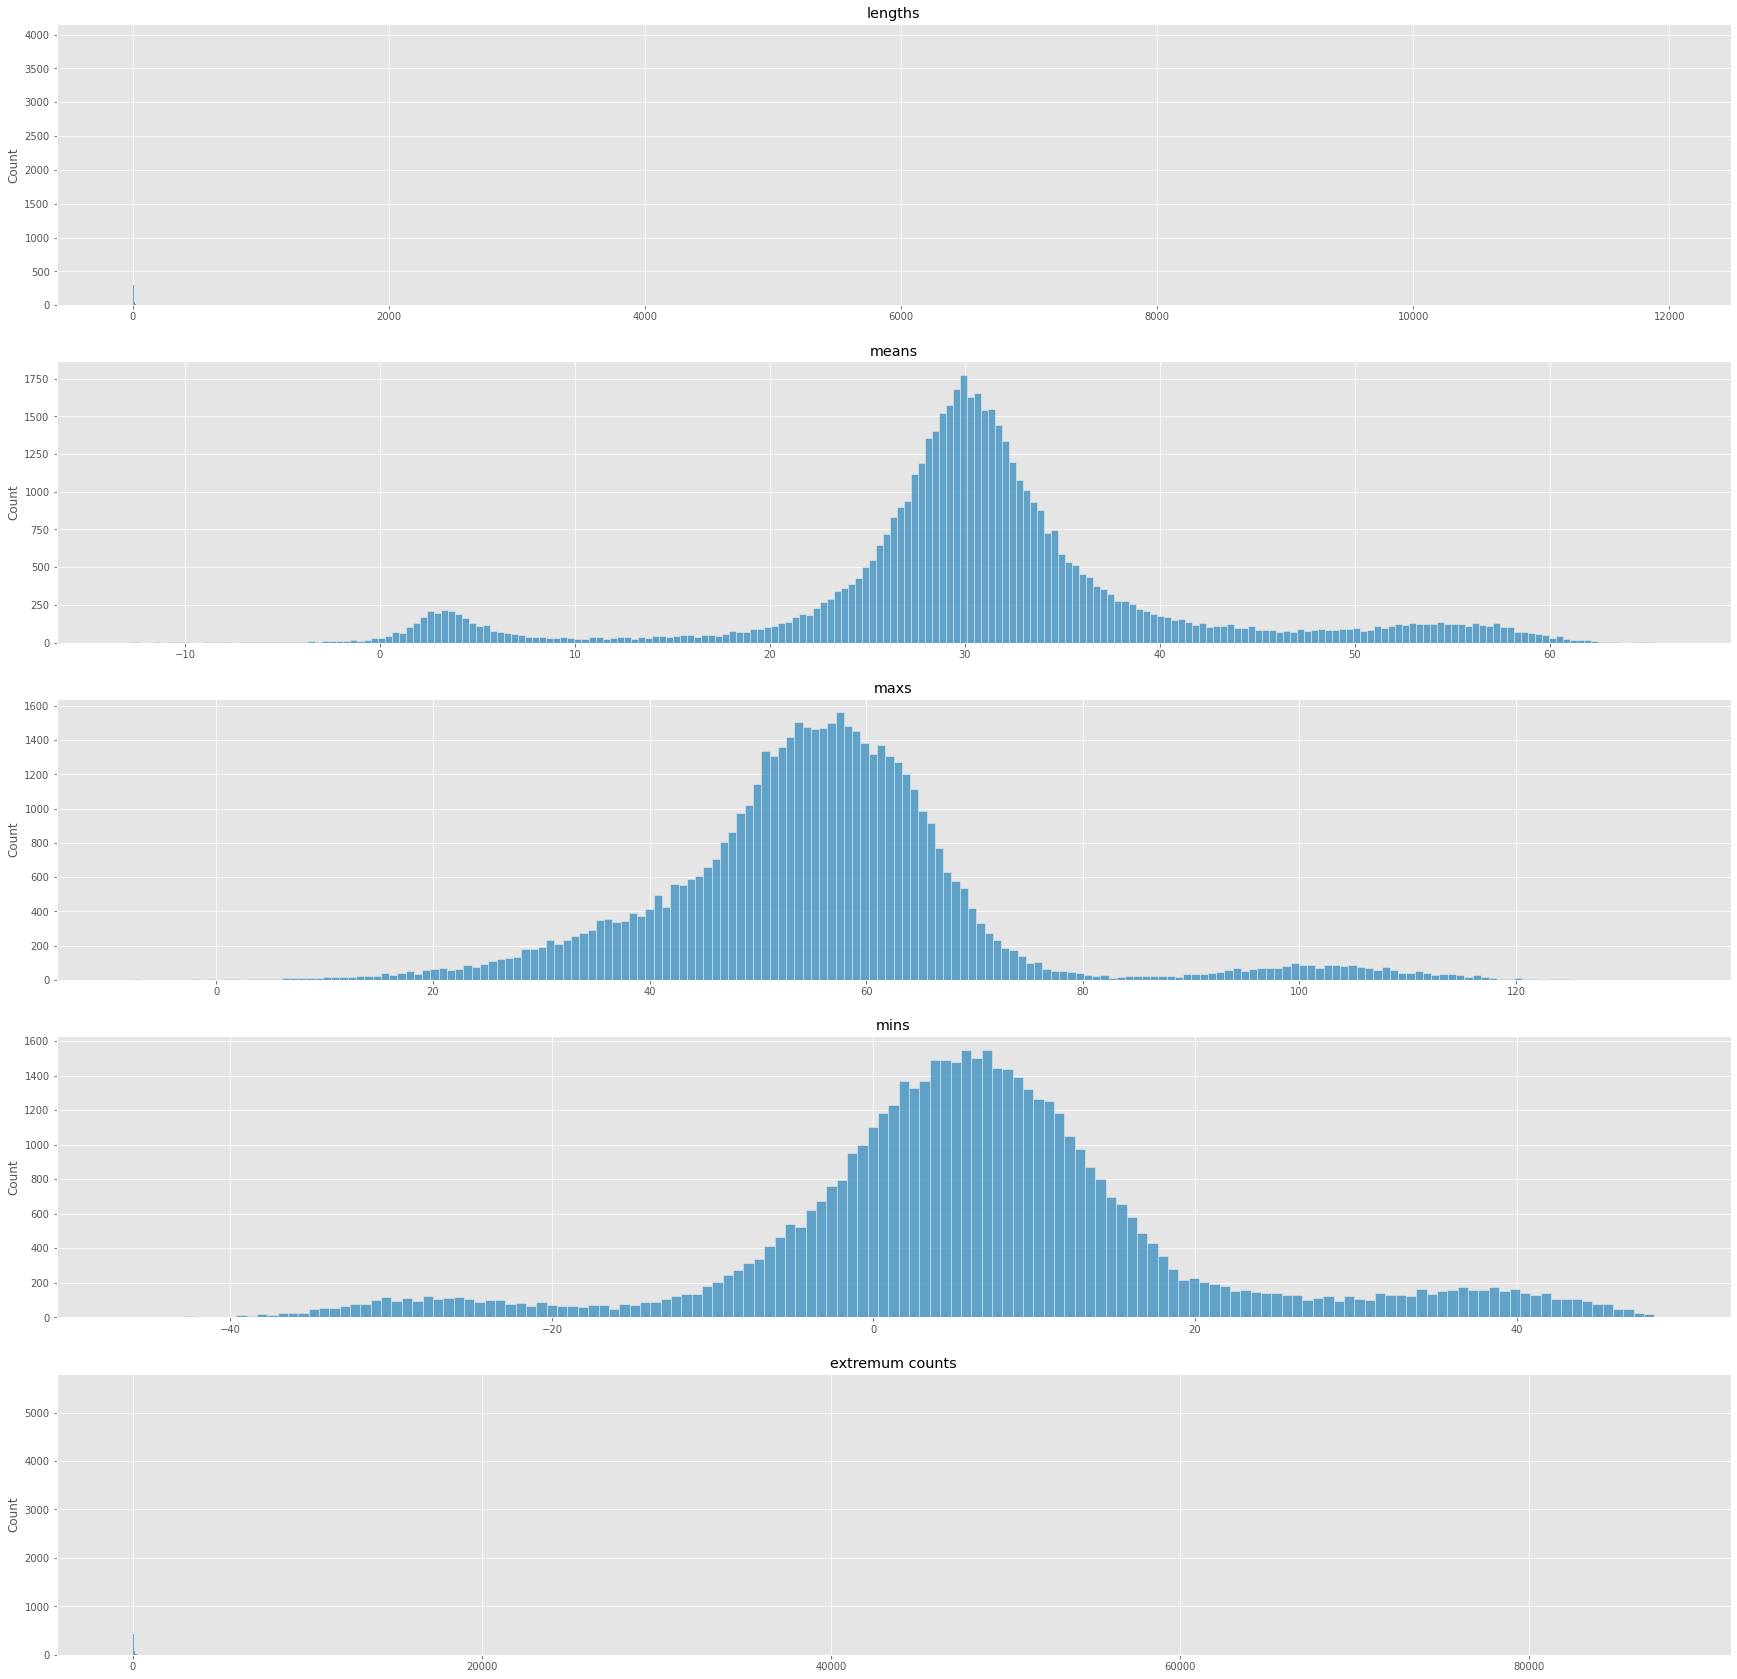

In [14]:
doubleX=get_extracted_features(arr_double, plot=True).T

In [16]:
df_double=pd.DataFrame(doubleX, columns=["length", "mean", "max", "min", "extremum"])

In [18]:
df_simple.describe()

,length,mean,max,min,extremum
count,22039.000000,22039.000000,22039.000000,22039.000000,22039.000000
mean,5.133861,36.880636,62.568330,20.211709,37.453560
std,12.723698,10.550761,23.374478,12.517944,93.952225
min,0.180000,-6.224567,-3.326128,-14.125677,1.000000
25%,1.260000,32.276848,48.229324,14.225583,9.000000
50%,3.040000,34.247925,52.659233,17.265463,21.000000
75%,6.490000,37.525126,74.093597,21.563379,47.000000
max,1434.890015,82.529396,120.786629,69.284660,10587.000000


In [17]:
df_double.describe()

,length,mean,max,min,extremum
count,50957.000000,50957.000000,50957.000000,50957.000000,50957.000000
mean,4.803236,30.697007,55.815615,6.511179,35.088114
std,76.289583,10.365965,15.208856,13.591141,561.095488
min,0.180000,-12.683914,-7.722728,-46.078430,1.000000
25%,0.960000,27.299438,48.294945,0.185759,7.000000
50%,2.030000,30.400698,55.686272,6.107318,15.000000
75%,4.460000,33.977844,62.497509,12.147684,33.000000
max,11883.219727,65.362762,132.776047,48.582317,87189.000000


In [15]:
doubleX.shape

(50957, 5)

In [21]:
X=np.concatenate((simpleX, doubleX))
Y=np.concatenate((np.zeros(len(simpleX)),np.ones(len(doubleX))))

In [32]:
X.shape
Y.shape

(72996,)

In [19]:
from sklearn import svm, model_selection

In [31]:
X_train, X_test, y_train, y_test=model_selection.train_test_split(normalize(X),Y, train_size=0.7, random_state=3)

clf = svm.SVC()
clf.fit(X_train, y_train)

AxisError: axis 1 is out of bounds for array of dimension 1

In [35]:
clf.score(X_test,y_test)

0.8338736928626878

In [1]:
import torch.nn as nn
import torch 
import torch.nn.functional as F 
from torch.autograd import Variable
from torchvision import transforms, datasets 

In [23]:
X_chunks=[]
Y_chunks=[]
X=np.concatenate((arr_simple,arr_double))
print("Single bulky shape: {} \n Double bulky shape: {}".format(arr_simple.shape, arr_double.shape))
print(X.shape)
for label, row in zip(Y,X):
    for y,x in helpers.split_in_k(label,row,6):
        Y_chunks.append(y)
        X_chunks.append(extract_features(x))

Single bulky shape: (22039,) 
 Double bulky shape: (50957,)
(72996,)


In [26]:
embed_dim = 128
lstm_out = 1
batch_size= 32

In [48]:
import itertools as it

In [49]:
params_list={"num_blocks":[1,2,3,4,5,6],
"lr":[0.1,0.05,0.01],
"hidden_dim":[4,5],
"num_epochs":[200]
}
param_combinations = list(it.product(*(params_list[param_name] for param_name in params_list.keys())))


In [50]:
len(param_combinations)

90